# **제17장 순환 기반 시퀀스 모델의 SCFI 예측**

그래프에 한글을 출력하는 경우 한글폰트를 사전에 설치한다.

다음의 한글폰트설치.ipynb의 한글폰트를 설치하는 코드를 복사한다.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from scipy.stats import shapiro, gaussian_kde
from scipy.signal import find_peaks
from google.colab import files
import os

# 📁 1. 한글 폰트 업로드 및 설정
print("📌 한글 폰트(.ttf)를 업로드하세요")
uploaded_fonts = files.upload()
font_path = list(uploaded_fonts.keys())[0]
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = fm.FontProperties(fname=font_path).get_name()
plt.rcParams['axes.unicode_minus'] = False



📌 한글 폰트(.ttf)를 업로드하세요


Saving NanumBarunGothic.ttf to NanumBarunGothic.ttf


# **복합 SCFI 예측모델의 개발을 요청하자**

# 도표 17-8. 복합 SCFI 에측모형 개발 ChatGPT 요청 내용

복합 SCFI를 종속변수로 갖는 RNN, LSTM, GRU 모형을 개발한다.
- SCFI_C: 복합SCFI, 종속변수
- 아래 변수는 모두 독립변수 후보이다.
  YYYYMM 년월, CH_EXP 중국수출량, FLEET_DEV 명목선복량, G_RELI 선박의 글로벌 정시성,
  ACTUAL_SHIP_CAPACITY 실선복량, DEMAND_SUPPLY_RATIO 수요공급비율, DEMAND_FORECAST 수요전망, SUPPLY_FORECAST 공급전망
- 계절성을 반영하기 위하여 YYYMM에 대해 1월을 제외한 2월부터 12월까지 각각을 나타내는 원-핫 인코딩된 컬럼들을 생성하여 모델링
  1) data['Month'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m').dt.month
  2) month_one_hot = pd.get_dummies(data['Month'], prefix='Month').iloc[:, 1:]  # 첫 번째 열(1월) 제외
- 전체 데이터의 마지막 2021년 10월부터 2023년 2월까지는 테스트데이터로 분리함
- 훈련 데이터를 가지고 각 모형을 만들고나서, 그 모형에 기반하여 훈련 데이터를 예측하고 모형별 훈련 데이터에 대한 RMSE를 계산
- 훈련 데이터를 가지고 각 모형을 만들고나서, 그 모형에 기반하여 테스트 데이터를 예측하고 모형별 테스트 데이터에 대한 RMSE를 계산
- 모형별 훈련데이터에 대한 RMSE, 테스트데이터에 대한 RMSE을 테이블 형태로 출력한다.
- 훈련 데이터를 가지고 각 모형을 만들고나서 전체 데이터 실적, 예측값을 세개 모형을 하나의 그래프로 그려줘
  단, 그래프에서 훈련이터 예측값은 파란색, 테스트데이터 예측값은 빨간색, 실적은 검은색으로 그려줘(X축은 YYYYMM)
- 전체 데이터를 가지고 각 모형을 만들고나서, 그 모형에 기반하여 전체 데이터를 예측하고 모형별 RMSE를 계산
- 입출력 데이터는 "/content/sample_data/" 폴더에 위치한다.
- 각 모형의 수행시간도 별도의 테이블로 만들어줘.
- 모형이 수행하는 과정은 출력하지 않도록 하다.
- 데이터 전처리는 아래 코드 사용함
# Extract the month and create one-hot encoded columns
data['Month'] = pd.to_datetime(data['YYYYMM'], format='%Y-%m').dt.month
month_one_hot = pd.get_dummies(data['Month'], prefix='Month').iloc[:, 1:]  
# Join the one-hot encoded columns with the original dataframe
data_with_months = data.join(month_one_hot)
# Prepare the data for modeling
X = data_with_months.drop(['YYYYMM', 'SCFI_C', 'Month'], axis=1)  # Independent variables
y = data_with_months['SCFI_C']  # Dependent variable

# **이하 은닉칭 활성화 함수 Relu 사용**


# (1차 모델) 학습 과정 및 진행 과정이 화면에 출력(실행 값 변동, 화면 출력 가독성 저하)
- 도표 17-9. 하이퍼파라미터 튜닝 전 3개 모델의 1차 예측 결과 비교(1차 모델)




🔵 RNN 모델 학습 시작...
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1053
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0582
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0366
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0225
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0150
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0105
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0084
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0062
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0049
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0042
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0036
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0025
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0022
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0019
Epoch 16/100
6/6 ━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0618
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0571 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0534 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0500 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0466 
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0434 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0405 
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0381 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0362 
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0347
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0333 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0320  
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0306 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0291 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0274  
Epoch 16/100
6/6 ━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0559
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0421 
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0342 
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0300 
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0268
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0240 
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0213
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0187 
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0161  
Epoch 10/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0135 
Epoch 11/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0110 
Epoch 12/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 
Epoch 13/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 
Epoch 14/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0054 
Epoch 15/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0043
Epoch 16/100
6/6 ━━━━━━━━━━━━━━

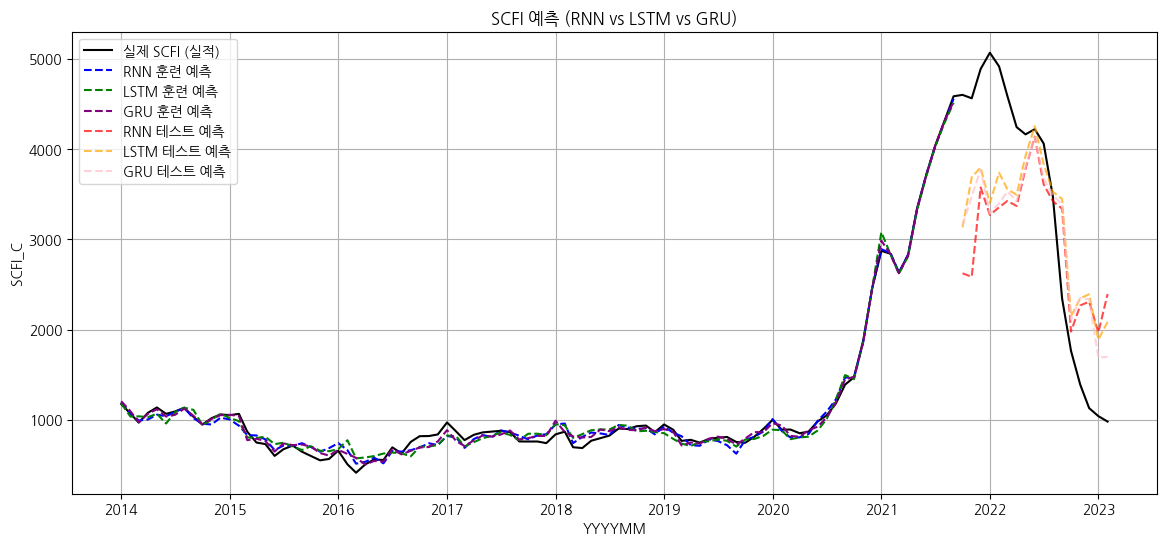

In [ ]:
# ================================
#  📌 SCFI 예측: RNN vs LSTM vs GRU 비교
# ================================

# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# -------------------------------
#  1️⃣ 데이터 로드 및 전처리
# -------------------------------
# 📌 엑셀 파일 경로 설정 (Colab에 업로드한 경우 직접 지정)
file_path = "/content/sample_data/전처리_SCFI.xlsx"

# 엑셀 데이터 로드
df = pd.read_excel(file_path)

# YYYYMM을 datetime 형식으로 변환
df['YYYYMM'] = pd.to_datetime(df['YYYYMM'], format='%Y-%m')

# 월(Month) 컬럼 생성 및 원-핫 인코딩
df['Month'] = df['YYYYMM'].dt.month
month_one_hot = pd.get_dummies(df['Month'], prefix='Month').iloc[:, 1:]  # 1월 제외

# 원-핫 인코딩된 컬럼 추가
df_with_months = df.join(month_one_hot)

# 독립변수(X), 종속변수(y) 분리
X = df_with_months.drop(['YYYYMM', 'SCFI_C', 'Month'], axis=1)
y = df_with_months['SCFI_C']

# 훈련/테스트 데이터 분할 (2021년 10월 이전: 훈련, 이후: 테스트)
train_data = df[df['YYYYMM'] < '2021-10-01']
test_data = df[df['YYYYMM'] >= '2021-10-01']

X_train = X.iloc[:len(train_data)]
y_train = y.iloc[:len(train_data)]

X_test = X.iloc[len(train_data):]
y_test = y.iloc[len(train_data):]

# -------------------------------
#  2️⃣ 데이터 정규화 (MinMax Scaling)
# -------------------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 훈련/테스트 데이터 변환
X_train_scaled = X_scaled[:len(train_data)]
X_test_scaled = X_scaled[len(train_data):]

y_train_scaled = y_scaled[:len(train_data)]
y_test_scaled = y_scaled[len(train_data):]

# RNN 입력 형태 변환 (samples, timesteps, features)
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# -------------------------------
#  3️⃣ 모델 학습 함수 정의
# -------------------------------
def build_and_train_model(model_type):
    """ RNN, LSTM, GRU 모델을 학습하고 예측값 반환 """
    model = Sequential()

    if model_type == "RNN":
        model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
        model.add(SimpleRNN(30, activation='relu'))
    elif model_type == "LSTM":
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
        model.add(LSTM(30, activation='relu'))
    elif model_type == "GRU":
        model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
        model.add(GRU(30, activation='relu'))

    model.add(Dense(1))  # 출력층
    model.compile(optimizer='adam', loss='mse')

    model.fit(X_train_rnn, y_train_scaled, epochs=100, batch_size=16, verbose=1)

    return model

# -------------------------------
#  4️⃣ 모델 학습 및 예측
# -------------------------------
models = {}
predictions = {}

for model_type in ["RNN", "LSTM", "GRU"]:
    print(f"\n🔵 {model_type} 모델 학습 시작...")

    # 모델 학습
    models[model_type] = build_and_train_model(model_type)

    # 훈련 데이터 예측
    y_train_pred_scaled = models[model_type].predict(X_train_rnn)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

    # 테스트 데이터 예측
    y_test_pred_scaled = models[model_type].predict(X_test_rnn)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

    # 결과 저장
    predictions[model_type] = {"train": y_train_pred, "test": y_test_pred}

# -------------------------------
#  5️⃣ RMSE 계산 및 테이블 출력
# -------------------------------
rmse_results = {}

for model_type in ["RNN", "LSTM", "GRU"]:
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions[model_type]["train"]))
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions[model_type]["test"]))
    rmse_results[model_type] = [rmse_train, rmse_test]

# 결과 테이블 출력
rmse_df = pd.DataFrame(rmse_results, index=["Train RMSE", "Test RMSE"])
print("\n📌 모델별 RMSE 비교")
print(rmse_df)

# -------------------------------
#  6️⃣ 예측 결과 시각화
# -------------------------------
plt.figure(figsize=(14,6))

# 실적 데이터
plt.plot(df["YYYYMM"], y, label="실제 SCFI (실적)", color='black', linestyle='solid')

# 훈련 데이터 예측
for model_type, color in zip(["RNN", "LSTM", "GRU"], ["blue", "green", "purple"]):
    plt.plot(train_data["YYYYMM"], predictions[model_type]["train"], label=f"{model_type} 훈련 예측", color=color, linestyle='dashed')

# 테스트 데이터 예측
for model_type, color in zip(["RNN", "LSTM", "GRU"], ["red", "orange", "pink"]):
    plt.plot(test_data["YYYYMM"], predictions[model_type]["test"], label=f"{model_type} 테스트 예측", color=color, linestyle='dashed', alpha=0.7)

plt.xlabel("YYYYMM")
plt.ylabel("SCFI_C")
plt.title("SCFI 예측 (RNN vs LSTM vs GRU)")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# -------------------------------
#  7️⃣ 전체 데이터 학습 후 RMSE 계산
# -------------------------------
# 전체 데이터를 학습하기 위해 데이터 변환
X_rnn = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# 전체 데이터 예측 결과 저장할 딕셔너리
total_predictions = {}
total_rmse_results = {}

for model_type in ["RNN", "LSTM", "GRU"]:
    print(f"\n🔵 {model_type} 모델 전체 데이터 학습 시작...")

    # 모델을 전체 데이터로 다시 학습
    models[model_type].fit(X_rnn, y_scaled, epochs=100, batch_size=16, verbose=1)

    # 전체 데이터 예측
    y_total_pred_scaled = models[model_type].predict(X_rnn)
    y_total_pred = scaler_y.inverse_transform(y_total_pred_scaled)

    # RMSE 계산
    rmse_total = np.sqrt(mean_squared_error(y, y_total_pred))

    # 결과 저장
    total_predictions[model_type] = y_total_pred
    total_rmse_results[model_type] = rmse_total

# 결과 테이블 출력
total_rmse_df = pd.DataFrame(total_rmse_results, index=["Total RMSE"])
print("\n📌 전체 데이터 학습 후 RMSE 비교")
print(total_rmse_df)



🔵 RNN 모델 전체 데이터 학습 시작...
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0108 
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0078 
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0059 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0050 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0043 
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0037 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033  
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0030 
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0027 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0024 
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0022      
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0020     
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019      
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018     
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s

# **(2차 모델) 훈련과정이 화면에 출력되지 않는 경우(실행시 값 변동)**

-도표 17-10. 하이퍼파라미터 튜닝 전 3개 모형의 2차 예측 결과 비교(2차 모델)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

📌 모델별 RMSE 비교
                   RNN        LSTM          GRU
Train RMSE   67.824119   76.990146    98.328340
Test RMSE   966.118615  921.073934  1012.728366
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

📌 전체 데이터 학습 후 RMSE 비교
                   RNN       LSTM         GRU
Total RMSE  139.980279  148.99838  135.637071

📌 모델별 수행 시간 비교 (초)
                           RNN       LSTM        GRU
Train Time            9.027723  10.014740  10.650182
Total Execution Time  9.875044  10.814094  12.126623
Total Train Time      6.790868   5.927343   7.266173


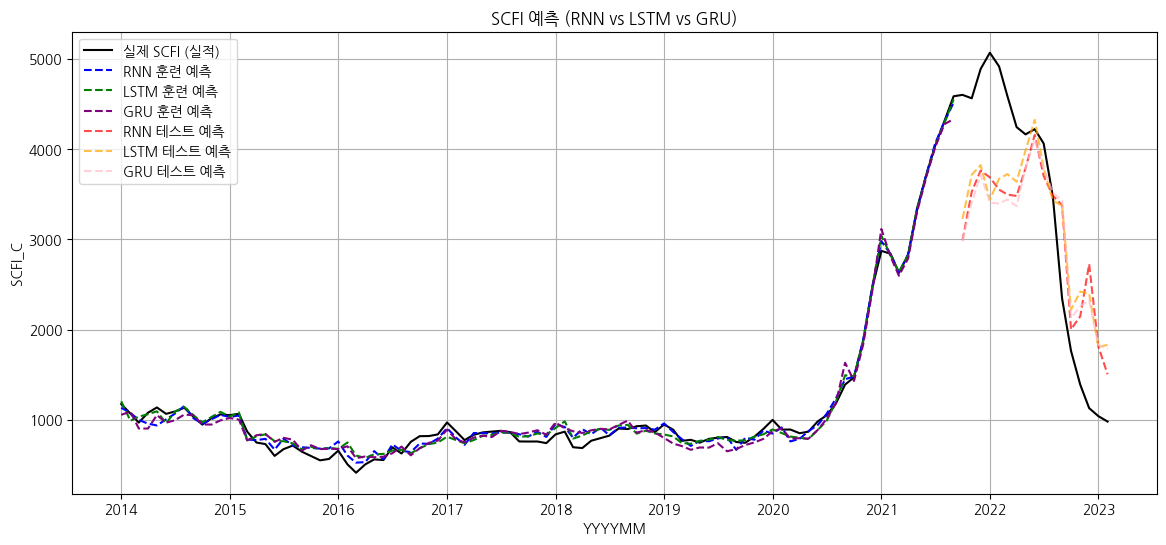

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import time

# -------------------------------
#  1️⃣ 데이터 로드 및 전처리
# -------------------------------
file_path = "/content/sample_data/전처리_SCFI.xlsx"

df = pd.read_excel(file_path)
df['YYYYMM'] = pd.to_datetime(df['YYYYMM'], format='%Y-%m')

df['Month'] = df['YYYYMM'].dt.month
month_one_hot = pd.get_dummies(df['Month'], prefix='Month').iloc[:, 1:]

df_with_months = df.join(month_one_hot)
X = df_with_months.drop(['YYYYMM', 'SCFI_C', 'Month'], axis=1)
y = df_with_months['SCFI_C']

train_data = df[df['YYYYMM'] < '2021-10-01']
test_data = df[df['YYYYMM'] >= '2021-10-01']

X_train = X.iloc[:len(train_data)]
y_train = y.iloc[:len(train_data)]

X_test = X.iloc[len(train_data):]
y_test = y.iloc[len(train_data):]

# -------------------------------
#  2️⃣ 데이터 정규화 (MinMax Scaling)
# -------------------------------
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

X_train_scaled = X_scaled[:len(train_data)]
X_test_scaled = X_scaled[len(train_data):]

y_train_scaled = y_scaled[:len(train_data)]
y_test_scaled = y_scaled[len(train_data):]

X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# -------------------------------
#  3️⃣ 모델 학습 함수 정의
# -------------------------------
def build_and_train_model(model_type):
    """ RNN, LSTM, GRU 모델을 학습하고 예측값 반환 """
    model = Sequential()

    if model_type == "RNN":
        model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
        model.add(SimpleRNN(30, activation='relu'))
    elif model_type == "LSTM":
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
        model.add(LSTM(30, activation='relu'))
    elif model_type == "GRU":
        model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
        model.add(GRU(30, activation='relu'))

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    start_time = time.time()
    model.fit(X_train_rnn, y_train_scaled, epochs=100, batch_size=16, verbose=0)  # 출력 없이 학습
    training_time = time.time() - start_time

    return model, training_time

# -------------------------------
#  4️⃣ 모델 학습 및 예측
# -------------------------------
models = {}
predictions = {}
training_times = {}

for model_type in ["RNN", "LSTM", "GRU"]:
    start_time = time.time()

    # 모델 학습
    models[model_type], training_time = build_and_train_model(model_type)

    # 훈련 데이터 예측
    y_train_pred_scaled = models[model_type].predict(X_train_rnn)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

    # 테스트 데이터 예측
    y_test_pred_scaled = models[model_type].predict(X_test_rnn)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

    # 실행 시간 저장
    execution_time = time.time() - start_time
    training_times[model_type] = [training_time, execution_time]

    predictions[model_type] = {"train": y_train_pred, "test": y_test_pred}

# -------------------------------
#  5️⃣ RMSE 계산 및 테이블 출력
# -------------------------------
rmse_results = {}

for model_type in ["RNN", "LSTM", "GRU"]:
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions[model_type]["train"]))
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions[model_type]["test"]))
    rmse_results[model_type] = [rmse_train, rmse_test]

rmse_df = pd.DataFrame(rmse_results, index=["Train RMSE", "Test RMSE"])
print("\n📌 모델별 RMSE 비교")
print(rmse_df)

# -------------------------------
#  6️⃣ 전체 데이터 학습 후 RMSE 계산
# -------------------------------
X_rnn = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

total_predictions = {}
total_rmse_results = {}

for model_type in ["RNN", "LSTM", "GRU"]:
    start_time = time.time()

    models[model_type].fit(X_rnn, y_scaled, epochs=100, batch_size=16, verbose=0)  # 출력 없이 학습
    training_time = time.time() - start_time

    y_total_pred_scaled = models[model_type].predict(X_rnn)
    y_total_pred = scaler_y.inverse_transform(y_total_pred_scaled)

    rmse_total = np.sqrt(mean_squared_error(y, y_total_pred))

    total_predictions[model_type] = y_total_pred
    total_rmse_results[model_type] = rmse_total
    training_times[model_type].append(training_time)

total_rmse_df = pd.DataFrame(total_rmse_results, index=["Total RMSE"])
print("\n📌 전체 데이터 학습 후 RMSE 비교")
print(total_rmse_df)

# -------------------------------
#  7️⃣ 모델 수행 시간 테이블 출력
# -------------------------------
execution_df = pd.DataFrame(training_times, index=["Train Time", "Total Execution Time", "Total Train Time"])
print("\n📌 모델별 수행 시간 비교 (초)")
print(execution_df)

# -------------------------------
#  8️⃣ 예측 결과 시각화
# -------------------------------
plt.figure(figsize=(14,6))

plt.plot(df["YYYYMM"], y, label="실제 SCFI (실적)", color='black', linestyle='solid')

for model_type, color in zip(["RNN", "LSTM", "GRU"], ["blue", "green", "purple"]):
    plt.plot(train_data["YYYYMM"], predictions[model_type]["train"], label=f"{model_type} 훈련 예측", color=color, linestyle='dashed')

for model_type, color in zip(["RNN", "LSTM", "GRU"],  ["red", "orange", "pink"]):
    plt.plot(test_data["YYYYMM"], predictions[model_type]["test"], label=f"{model_type} 테스트 예측", color=color, linestyle='dashed', alpha=0.7)

plt.xlabel("YYYYMM")
plt.ylabel("SCFI_C")
plt.title("SCFI 예측 (RNN vs LSTM vs GRU)")
plt.legend()
plt.grid()
plt.show()


# **모델을 만들기전에 데이터를 준비분석하고 고도화하자**

# **램덤 시드로 동일 결과가 나오도록 하자**



# **모델을 생성하고 학습을 시키자**

# (3차 모델) 랜덤시드 고정과 한글 주석처리(튜닝 전)
- 도표 17-11. 하이퍼파라미터 튜닝 전 3개 모델의 3차 예측 결과 비교(3차 모델)
- 도표 17-15. 랜덤 시드 고정 함수
- 하이퍼파라미터 튜닝 전

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

📌 모델별 RMSE 비교
                    RNN        LSTM          GRU
Train RMSE    59.624286   91.585226    62.668825
Test RMSE   1036.323383  948.129620  1000.961280

📌 모델별 수행 시간 비교 (초)
                            RNN       LSTM        GRU
Train Time            10.832351  11.782210  13.286438
Total Execution Time  11.610868  12.641484  14.791532


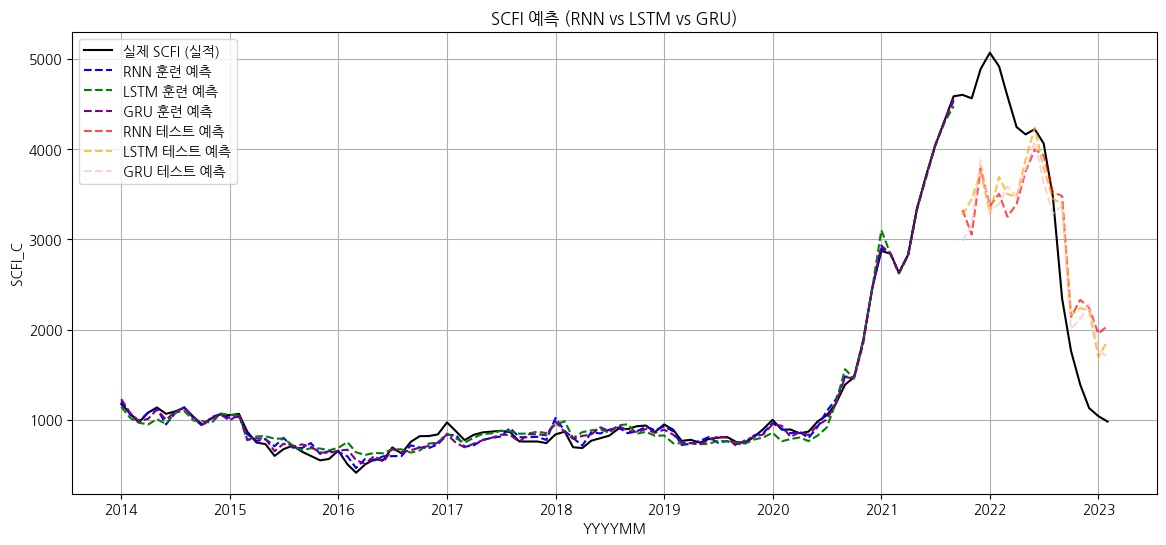

In [ ]:
import pandas as pd  # 데이터 처리 및 분석을 위한 pandas 라이브러리
import numpy as np  # 수치 계산 및 배열 처리를 위한 NumPy 라이브러리
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 matplotlib 라이브러리
import tensorflow as tf  # 딥러닝 프레임워크 TensorFlow 불러오기

from tensorflow.keras.models import Sequential  # 순차 모델(Sequential) 구조 불러오기
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense  # 순환신경망(RNN), LSTM, GRU, 완전연결(Dense) 층 불러오기

from sklearn.preprocessing import MinMaxScaler  # 데이터 정규화를 위한 MinMaxScaler
from sklearn.metrics import mean_squared_error  # 예측 성능 평가를 위한 RMSE 계산용 MSE 함수

import time  # 코드 실행 시간 측정을 위한 time 모듈


# -------------------------------
#  1️⃣ 데이터 로드 및 전처리
# -------------------------------

# Colab에 업로드한 엑셀 파일 경로 설정
file_path = "/content/sample_data/전처리_SCFI.xlsx"

# 엑셀 데이터 로드
df = pd.read_excel(file_path)

# YYYYMM을 날짜(datetime) 형식으로 변환
df['YYYYMM'] = pd.to_datetime(df['YYYYMM'], format='%Y-%m')

# 월(Month) 컬럼 생성 후 원-핫 인코딩 (1월 제외)
df['Month'] = df['YYYYMM'].dt.month
month_one_hot = pd.get_dummies(df['Month'], prefix='Month').iloc[:, 1:]

# 원-핫 인코딩한 월 데이터를 기존 데이터프레임에 추가
df_with_months = df.join(month_one_hot)

# 독립변수(X), 종속변수(y) 분리
X = df_with_months.drop(['YYYYMM', 'SCFI_C', 'Month'], axis=1)  # 종속변수(SCFI_C) 제외
y = df_with_months['SCFI_C']  # 종속변수

# 훈련(2021년 10월 이전) / 테스트(2021년 10월 이후) 데이터 분할
train_data = df[df['YYYYMM'] < '2021-10-01']
test_data = df[df['YYYYMM'] >= '2021-10-01']

X_train = X.iloc[:len(train_data)]
y_train = y.iloc[:len(train_data)]

X_test = X.iloc[len(train_data):]
y_test = y.iloc[len(train_data):]

# -------------------------------
#  2️⃣ 데이터 정규화 (MinMax Scaling)
# -------------------------------

# MinMaxScaler를 사용하여 X(독립변수)와 y(종속변수) 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# 훈련 및 테스트 데이터를 정규화된 값으로 변환
X_train_scaled = X_scaled[:len(train_data)]
X_test_scaled = X_scaled[len(train_data):]

y_train_scaled = y_scaled[:len(train_data)]
y_test_scaled = y_scaled[len(train_data):]

# RNN 입력 형식으로 변환 (samples, timesteps, features)
X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# ================================
#  📌 랜덤 시드 고정 함수 (재현성 확보)
# ================================
import random  # 파이썬 내장 랜덤 라이브러리 (난수 생성)
import os  # 운영체제(OS) 관련 기능 제공

# 랜덤 시드를 고정하는 함수 (같은 실험 결과를 얻기 위해 설정)
def set_random_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)  # 파이썬의 해시 기반 난수를 고정 (재현성 보장)
    random.seed(seed)  # 파이썬 내장 랜덤 시드 고정
    np.random.seed(seed)  # 넘파이 난수 생성 시드 고정
    tf.random.set_seed(seed)  # 텐서플로우 난수 생성 시드 고정 (모델 학습의 일관성 유지)

# 위에서 정의한 시드 고정 함수를 실행하여 랜덤성 제어
set_random_seed(42)


# -------------------------------
#  3️⃣ RNN, LSTM, GRU 모델 학습 함수 정의
# -------------------------------

def build_and_train_model(model_type):
    """ RNN, LSTM, GRU 모델을 정의하고 학습하는 함수 """

    # Sequential 모델 생성
    model = Sequential()

    # 모델 타입에 따라 적절한 네트워크 구조 추가
    if model_type == "RNN":
        model.add(SimpleRNN(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
        model.add(SimpleRNN(30, activation='relu'))
    elif model_type == "LSTM":
        model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
        model.add(LSTM(30, activation='relu'))
    elif model_type == "GRU":
        model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
        model.add(GRU(30, activation='relu'))

    # 출력층 추가
    model.add(Dense(1))

    # 모델 컴파일 (Adam 옵티마이저 사용)
    model.compile(optimizer='adam', loss='mse')

    # 모델 학습 시간 측정 시작
    start_time = time.time()
    model.fit(X_train_rnn, y_train_scaled, epochs=100, batch_size=16, verbose=0)  # verbose=0으로 출력 숨김
    training_time = time.time() - start_time  # 학습 시간 측정 종료

    return model, training_time  # 모델과 학습 시간 반환

# -------------------------------
#  4️⃣ 모델 학습 및 예측
# -------------------------------

models = {}
predictions = {}
training_times = {}

for model_type in ["RNN", "LSTM", "GRU"]:
    start_time = time.time()

    # 모델 학습 및 학습 시간 저장
    models[model_type], training_time = build_and_train_model(model_type)

    # 훈련 데이터 예측
    y_train_pred_scaled = models[model_type].predict(X_train_rnn)
    y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

    # 테스트 데이터 예측
    y_test_pred_scaled = models[model_type].predict(X_test_rnn)
    y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

    # 전체 실행 시간 측정
    execution_time = time.time() - start_time
    training_times[model_type] = [training_time, execution_time]

    predictions[model_type] = {"train": y_train_pred, "test": y_test_pred}

# -------------------------------
#  5️⃣ 모델별 RMSE 계산 및 테이블 출력
# -------------------------------

rmse_results = {}

for model_type in ["RNN", "LSTM", "GRU"]:
    rmse_train = np.sqrt(mean_squared_error(y_train, predictions[model_type]["train"]))
    rmse_test = np.sqrt(mean_squared_error(y_test, predictions[model_type]["test"]))
    rmse_results[model_type] = [rmse_train, rmse_test]

rmse_df = pd.DataFrame(rmse_results, index=["Train RMSE", "Test RMSE"])
print("\n📌 모델별 RMSE 비교")
print(rmse_df)

# -------------------------------
#  6️⃣ 모델 수행 시간 테이블 출력
# -------------------------------

execution_df = pd.DataFrame(training_times, index=["Train Time", "Total Execution Time"])
print("\n📌 모델별 수행 시간 비교 (초)")
print(execution_df)

# -------------------------------
#  7️⃣ 예측 결과 시각화
# -------------------------------

plt.figure(figsize=(14,6))

# 실적 데이터 플롯
plt.plot(df["YYYYMM"], y, label="실제 SCFI (실적)", color='black', linestyle='solid')

# 모델별 예측 데이터 플롯
for model_type, color in zip(["RNN", "LSTM", "GRU"], ["blue", "green", "purple"]):
    plt.plot(train_data["YYYYMM"], predictions[model_type]["train"], label=f"{model_type} 훈련 예측", color=color, linestyle='dashed')

for model_type, color in zip(["RNN", "LSTM", "GRU"], ["red", "orange", "pink"]):
    plt.plot(test_data["YYYYMM"], predictions[model_type]["test"], label=f"{model_type} 테스트 예측", color=color, linestyle='dashed', alpha=0.7)

plt.xlabel("YYYYMM")
plt.ylabel("SCFI_C")
plt.title("SCFI 예측 (RNN vs LSTM vs GRU)")
plt.legend()
plt.grid()
plt.show()


# **하이퍼파라미터를 튜닝하자**

# **(4차 모델) 하이퍼파라미터 튜닝**


In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


도표 17-22. 하이퍼파라미터 튜닝 후 3개 모델의 4차 예측 결과 비교(4차 모델)

In [ ]:
# ================================
#  📌 SCFI 예측: RNN vs LSTM vs GRU 하이퍼파라미터 튜닝
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# -------------------------------
#  1️⃣ 데이터 로드 및 전처리
# -------------------------------

file_path = "/content/sample_data/전처리_SCFI.xlsx"

df = pd.read_excel(file_path)
df['YYYYMM'] = pd.to_datetime(df['YYYYMM'], format='%Y-%m')

df['Month'] = df['YYYYMM'].dt.month
month_one_hot = pd.get_dummies(df['Month'], prefix='Month').iloc[:, 1:]

df_with_months = df.join(month_one_hot)
X = df_with_months.drop(['YYYYMM', 'SCFI_C', 'Month'], axis=1)
y = df_with_months['SCFI_C']

train_data = df[df['YYYYMM'] < '2021-10-01']
test_data = df[df['YYYYMM'] >= '2021-10-01']

X_train = X.iloc[:len(train_data)]
y_train = y.iloc[:len(train_data)]

X_test = X.iloc[len(train_data):]
y_test = y.iloc[len(train_data):]

# -------------------------------
#  2️⃣ 데이터 정규화 (MinMax Scaling)
# -------------------------------

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

X_train_scaled = X_scaled[:len(train_data)]
X_test_scaled = X_scaled[len(train_data):]

y_train_scaled = y_scaled[:len(train_data)]
y_test_scaled = y_scaled[len(train_data):]

X_train_rnn = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_rnn = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# -------------------------------
#  3️⃣ 하이퍼파라미터 튜닝을 위한 모델 생성 함수
# -------------------------------

def build_model(hp, model_type):
    """ RNN, LSTM, GRU 모델을 생성하는 함수 """

    model = Sequential()

    # 첫 번째 순환층
    if model_type == "RNN":
        model.add(SimpleRNN(hp.Int('units_1', 30, 100, step=10), activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
        model.add(SimpleRNN(hp.Int('units_2', 20, 80, step=10), activation='relu'))
    elif model_type == "LSTM":
        model.add(LSTM(hp.Int('units_1', 30, 100, step=10), activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
        model.add(LSTM(hp.Int('units_2', 20, 80, step=10), activation='relu'))
    elif model_type == "GRU":
        model.add(GRU(hp.Int('units_1', 30, 100, step=10), activation='relu', return_sequences=True, input_shape=(1, X_train_scaled.shape[1])))
        model.add(GRU(hp.Int('units_2', 20, 80, step=10), activation='relu'))

    # Dropout 추가 (과적합 방지)
    model.add(Dropout(hp.Float('dropout', 0.0, 0.5, step=0.1)))

    # 출력층
    model.add(Dense(1))

    # 옵티마이저 학습률 조정
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])), loss='mse')

    return model

# -------------------------------
#  4️⃣ 하이퍼파라미터 튜닝 실행
# -------------------------------

tuner_results = {}
best_models = {}

for model_type in ["RNN", "LSTM", "GRU"]:
    tuner = kt.RandomSearch(
        lambda hp: build_model(hp, model_type),
        objective='val_loss',
        max_trials=5,
        executions_per_trial=1,
        directory='/content/sample_data/tuning_results',
        project_name=f'{model_type}_tuning'
    )

    tuner.search(X_train_rnn, y_train_scaled, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_models[model_type] = tuner.hypermodel.build(best_hps)

# -------------------------------
#  5️⃣ 최적 모델 학습 및 평가
# -------------------------------

rmse_results = {}
execution_times = {}

for model_type in ["RNN", "LSTM", "GRU"]:
    start_time = time.time()
    best_models[model_type].fit(X_train_rnn, y_train_scaled, epochs=100, batch_size=16, verbose=0)
    training_time = time.time() - start_time

    # 예측 수행
    y_train_pred = scaler_y.inverse_transform(best_models[model_type].predict(X_train_rnn))
    y_test_pred = scaler_y.inverse_transform(best_models[model_type].predict(X_test_rnn))

    # RMSE 계산
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

    rmse_results[model_type] = [rmse_train, rmse_test]
    execution_times[model_type] = training_time

# -------------------------------
#  6️⃣ 결과 테이블 출력
# -------------------------------

rmse_df = pd.DataFrame(rmse_results, index=["Train RMSE", "Test RMSE"])
print("\n📌 모델별 RMSE 비교")
print(rmse_df)

execution_df = pd.DataFrame(execution_times, index=["Training Time"])
print("\n📌 모델별 학습 시간 비교 (초)")
print(execution_df)


Reloading Tuner from /content/sample_data/tuning_results/RNN_tuning/tuner0.json
Reloading Tuner from /content/sample_data/tuning_results/LSTM_tuning/tuner0.json
Reloading Tuner from /content/sample_data/tuning_results/GRU_tuning/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

📌 모델별 RMSE 비교
                    RNN        LSTM         GRU
Train RMSE   126.548887  147.356088   86.476652
Test RMSE   1073.714861  954.424050  947.536734

📌 모델별 학습 시간 비교 (초)
                    RNN       LSTM        GRU
Training Time  8.784695  10.257232  11.084879


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


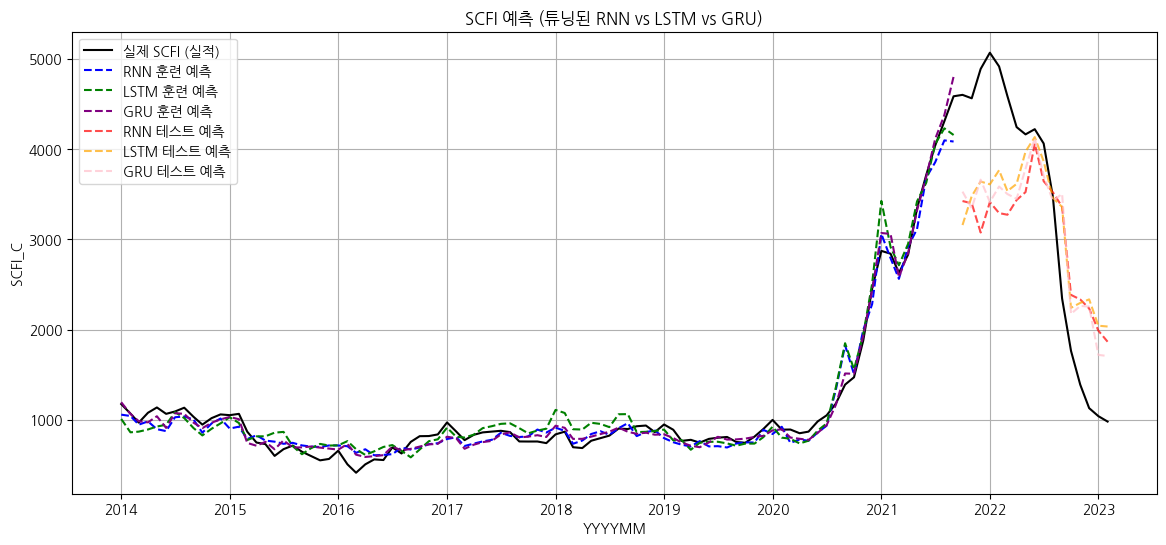

In [ ]:
# -------------------------------
#  7️⃣ 예측 결과 시각화 (훈련 + 테스트 예측 추가)
# -------------------------------

plt.figure(figsize=(14,6))

# 실적 데이터 (검은색)
plt.plot(df["YYYYMM"], y, label="실제 SCFI (실적)", color='black', linestyle='solid')

# 훈련 데이터 예측 (파란색)
for model_type, color in zip(["RNN", "LSTM", "GRU"], ["blue", "green", "purple"]):
    y_train_pred = scaler_y.inverse_transform(best_models[model_type].predict(X_train_rnn))
    plt.plot(train_data["YYYYMM"], y_train_pred, label=f"{model_type} 훈련 예측", color=color, linestyle='dashed')

# 테스트 데이터 예측 (빨간색)
for model_type, color in zip(["RNN", "LSTM", "GRU"], ["red", "orange", "pink"]):
    y_test_pred = scaler_y.inverse_transform(best_models[model_type].predict(X_test_rnn))
    plt.plot(test_data["YYYYMM"], y_test_pred, label=f"{model_type} 테스트 예측", color=color, linestyle='dashed', alpha=0.7)

plt.xlabel("YYYYMM")
plt.ylabel("SCFI_C")
plt.title("SCFI 예측 (튜닝된 RNN vs LSTM vs GRU)")
plt.legend()
plt.grid()
plt.show()


# **최신 데이터의 변동성을 반영하는 방안을 고민하자**

# **(5차 모델) 최근 변동성을 반영하여 전체 데이터를 기반으로 튜닝**

- 도표 17-23. 최신 변동성을 반영한 가중치 생성(5차 모델)
- 도표 17-24. 최근 데이터에 가중치를 설정하여 전체 데이터에 대한 하이퍼파라미터 튜닝 결과

Reloading Tuner from /content/sample_data/tuning_results/RNN_tuning/tuner0.json
Reloading Tuner from /content/sample_data/tuning_results/LSTM_tuning/tuner0.json
Reloading Tuner from /content/sample_data/tuning_results/GRU_tuning/tuner0.json


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step

📌 전체 데이터 학습 후 RMSE 비교
                   RNN        LSTM         GRU
Total RMSE  196.801773  236.893547  215.205259

📌 모델별 학습 시간 비교 (초)
                   RNN       LSTM        GRU
Training Time  9.20196  11.500897  12.773075
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


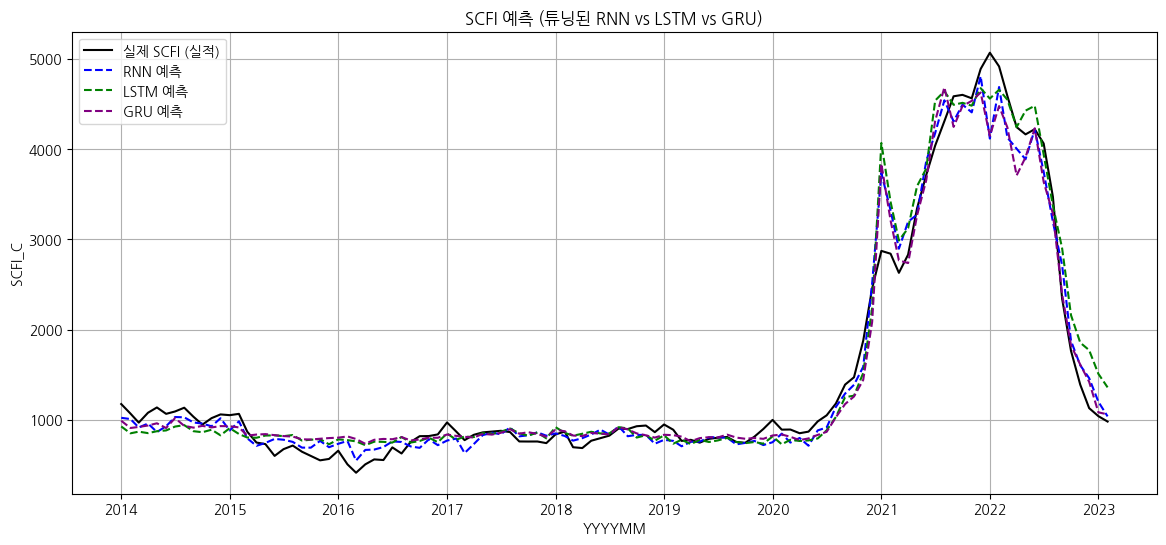

In [ ]:
# ================================
#  📌 SCFI 예측: 전체 데이터 기반 튜닝 & 최신 변동성 반영
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# -------------------------------
#  1️⃣ 데이터 로드 및 전처리
# -------------------------------

file_path = "/content/sample_data/전처리_SCFI.xlsx"

df = pd.read_excel(file_path)
df['YYYYMM'] = pd.to_datetime(df['YYYYMM'], format='%Y-%m')

df['Month'] = df['YYYYMM'].dt.month
month_one_hot = pd.get_dummies(df['Month'], prefix='Month').iloc[:, 1:]

df_with_months = df.join(month_one_hot)
X = df_with_months.drop(['YYYYMM', 'SCFI_C', 'Month'], axis=1)
y = df_with_months['SCFI_C']

# -------------------------------
#  2️⃣ 데이터 정규화 (MinMax Scaling)
# -------------------------------

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

X_rnn = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# -------------------------------
#  3️⃣ 최신 변동성을 반영한 가중치 생성
# -------------------------------
# 최근 데이터일수록 더 높은 가중치를 부여 (예: 가장 최근 데이터에 3배 가중치)
time_weight = np.linspace(1, 3, len(y_scaled))  # 1에서 3까지 선형 증가
sample_weights = time_weight / time_weight.sum()  # 가중치 정규화

# -------------------------------
#  4️⃣ 하이퍼파라미터 튜닝을 위한 모델 생성 함수
# -------------------------------

def build_model(hp, model_type):
    """ RNN, LSTM, GRU 모델을 생성하는 함수 (하이퍼파라미터 튜닝) """
    model = Sequential()

    # 첫 번째 순환층
    if model_type == "RNN":
        model.add(SimpleRNN(hp.Int('units_1', 30, 100, step=10), activation='relu', return_sequences=True, input_shape=(1, X_scaled.shape[1])))
        model.add(SimpleRNN(hp.Int('units_2', 20, 80, step=10), activation='relu'))
    elif model_type == "LSTM":
        model.add(LSTM(hp.Int('units_1', 30, 100, step=10), activation='relu', return_sequences=True, input_shape=(1, X_scaled.shape[1])))
        model.add(LSTM(hp.Int('units_2', 20, 80, step=10), activation='relu'))
    elif model_type == "GRU":
        model.add(GRU(hp.Int('units_1', 30, 100, step=10), activation='relu', return_sequences=True, input_shape=(1, X_scaled.shape[1])))
        model.add(GRU(hp.Int('units_2', 20, 80, step=10), activation='relu'))

    # Dropout 추가 (과적합 방지)
    model.add(Dropout(hp.Float('dropout', 0.0, 0.5, step=0.1)))

    # 출력층
    model.add(Dense(1))

    # Adam 옵티마이저 학습률 튜닝
    model.compile(optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])), loss='mse')

    return model

# -------------------------------
#  5️⃣ 하이퍼파라미터 튜닝 실행
# -------------------------------

tuner_results = {}
best_models = {}

for model_type in ["RNN", "LSTM", "GRU"]:
    tuner = kt.RandomSearch(
        lambda hp: build_model(hp, model_type),
        objective='val_loss',  # 검증 데이터의 RMSE 최소화
        max_trials=5,
        executions_per_trial=1,
        directory='/content/sample_data/tuning_results',
        project_name=f'{model_type}_tuning'
    )

    tuner.search(X_rnn, y_scaled, sample_weight=sample_weights, epochs=50, batch_size=16, validation_split=0.2, verbose=0)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_models[model_type] = tuner.hypermodel.build(best_hps)

# -------------------------------
#  6️⃣ 최적 모델 학습 및 평가
# -------------------------------

rmse_results = {}
execution_times = {}

for model_type in ["RNN", "LSTM", "GRU"]:
    start_time = time.time()
    best_models[model_type].fit(X_rnn, y_scaled, sample_weight=sample_weights, epochs=100, batch_size=16, verbose=0)
    training_time = time.time() - start_time

    # 예측 수행
    y_pred = scaler_y.inverse_transform(best_models[model_type].predict(X_rnn))

    # RMSE 계산
    rmse_total = np.sqrt(mean_squared_error(y, y_pred))

    rmse_results[model_type] = rmse_total
    execution_times[model_type] = training_time

# -------------------------------
#  7️⃣ 결과 테이블 출력
# -------------------------------

rmse_df = pd.DataFrame(rmse_results, index=["Total RMSE"])
print("\n📌 전체 데이터 학습 후 RMSE 비교")
print(rmse_df)

execution_df = pd.DataFrame(execution_times, index=["Training Time"])
print("\n📌 모델별 학습 시간 비교 (초)")
print(execution_df)

# -------------------------------
#  8️⃣ 예측 결과 시각화
# -------------------------------

plt.figure(figsize=(14,6))
plt.plot(df["YYYYMM"], y, label="실제 SCFI (실적)", color='black', linestyle='solid')

for model_type, color in zip(["RNN", "LSTM", "GRU"], ["blue", "green", "purple"]):
    y_pred = scaler_y.inverse_transform(best_models[model_type].predict(X_rnn))
    plt.plot(df["YYYYMM"], y_pred, label=f"{model_type} 예측", color=color, linestyle='dashed')

plt.xlabel("YYYYMM")
plt.ylabel("SCFI_C")
plt.title("SCFI 예측 (튜닝된 RNN vs LSTM vs GRU)")
plt.legend()
plt.grid()
plt.show()
